<a href="https://colab.research.google.com/github/Tbarkin121/ML_Examples/blob/main/Breakout_DeepQ_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [55]:
%matplotlib inline

In [56]:
!pip install stable-baselines3[extra]

In [57]:
import time

from stable_baselines3.common.env_util import make_atari_env, make_vec_env
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

import gym
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import keras
from keras import layers
from keras import models
from keras.layers import Dropout
from keras.layers import LeakyReLU

import random
np.random.seed(8675309)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [58]:
epochs = 1
episode_length = 100000
video_folder = 'logs/videos/'
video_length = 1000
model_folder = 'logs/models/'
monitor_folder = 'logs/monitor/'

# Use the Baseline Atari environment because of Deepmind helper functions
env_id = 'BreakoutNoFrameskip-v4'
# make_atari_env contains all the standard preprocessing for atari RL. 
# https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/env_util.py
env = make_atari_env(env_id, n_envs=1, seed=0, monitor_dir=monitor_folder)
env = VecFrameStack(env, n_stack=4)

# Box(4,) means that it is a Vector with 4 components
print("Observation space:", env.observation_space)
print("Shape:", env.observation_space.shape)
# Discrete(2) means that there is two discrete actions
print("Action space:", env.action_space)

Observation space: Box(0, 255, (84, 84, 4), uint8)
Shape: (84, 84, 4)
Action space: Discrete(4)


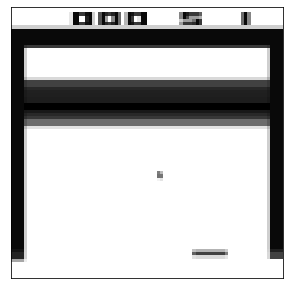

In [59]:
import matplotlib.pyplot as plt
env.reset()
for i in range(2):
  env.step( [env.action_space.sample()] )

next_state, reward, done, info = env.step( [env.action_space.sample()] )

for i in range(1):
  plt.figure(figsize=(5, 5))
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(next_state[0,:,:,i], cmap=plt.cm.binary)
  plt.show()


In [60]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [61]:
class DQN:
    def __init__(self, input_shape, output_shape):
      self.model = self.create_model(input_shape, output_shape)

    def create_model(self, input_shape, output_shape):
      inputs = layers.Input(shape=input_shape)
    
      x = inputs
      x = layers.Conv2D(16, (5, 5), strides=(2, 2), activation='relu')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Flatten()(x)
      x = layers.Dense(output_shape, activation='linear')(x)

      model = keras.Model(inputs, x)

      model.compile(
            loss='huber',
            metrics=['mse'],
            optimizer='RMSprop')
      
      return model



In [62]:
test = DQN(env.observation_space.shape, env.action_space.n)

state = env.reset()
print(state.shape)
print('Model Output = {}'.format(test.model(state)))

(1, 84, 84, 4)
Model Output = [[ -4.4294596  -7.138133  -10.071992   -1.018873 ]]


In [63]:
policy_net.model(state)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.135576 , 13.133005 , -1.6629822,  9.502362 ]], dtype=float32)>

In [64]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN(env.observation_space.shape, env.action_space.n)
target_net = DQN(env.observation_space.shape, env.action_space.n)
target_net.model.set_weights(policy_net.model.get_weights()) 

memory = ReplayMemory(10000)


steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
      return policy_net.model(state).max(1)[1].view(1, 1)
    else:
      return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        pass
        # display.clear_output(wait=True)
        # display.display(plt.gcf())

In [65]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    # print('!!!!!!!!!!!')
    # print(next_state_values.shape)
    # print(next_state_values.unsqueeze(1).shape)
    # print(reward_batch.shape)
    # print(reward_batch.squeeze().shape)
    # print('!!!!!!!!!!!')
    expected_state_action_values = (next_state_values.unsqueeze(1) * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)
    # print(state_action_values.shape)
    # print(expected_state_action_values.shape)
    # print('sleep for 5 sec')
    # time.sleep(5)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [66]:
state = env.reset()
print(state.shape)

action = select_action(state)
print(action.item())

(1, 84, 84, 4)


NameError: ignored

In [ ]:
def state_processing(state):
  state = state.squeeze(0)
  state = state.transpose((2, 0, 1))
  # print(state.shape)
  state = np.ascontiguousarray(state, dtype=np.float32) / 255
  state = torch.from_numpy(state)
  state = state.unsqueeze(0)
  # print(state.shape)
  return state

In [ ]:
num_episodes = 200
for i_episode in range(num_episodes):
    print('Episode = {}'.format(i_episode))
    # Initialize the environment and state
    state = state_processing(env.reset())
    for t in count():
        # Select and perform an action
        # print(state.shape)
        action = select_action(state)
        next_state, reward, done, info = env.step( [action.item()] )
        next_state = state_processing(next_state)
        reward = torch.tensor([reward], device=device)

        if not done:
            pass
        else:
            print('Are We Done?')
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        print('Target Update')
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
# env.render()
env.close()
plt.ioff()
plt.show()

In [ ]:
obs = env.reset()
obs = state_processing(obs)
action_values = policy_net(obs)
best_action = torch.argmax(action_values)
print(action_values)
print(best_action)

In [ ]:
env = make_atari_env(env_id, n_envs=1, seed=0, monitor_dir=monitor_folder)
env = VecFrameStack(env, n_stack=4)

# Video Record Attempt
obs = env.reset()
num_episodes = 50
# Record the video starting at the first step
vid_env = VecVideoRecorder(env, video_folder,
                      record_video_trigger=lambda x: x == 0, video_length=video_length,
                      name_prefix="Breakout_DeepDoubleQ_{}-{}".format(env_id, num_episodes))

obs = vid_env.reset()
obs = state_processing(obs)
for _ in range(video_length + 1):
    action_values = policy_net(obs)
    best_action = torch.argmax(action_values).numpy()
    # best_action = env.action_space.sample()
    # print(best_action)
    obs, rewards, dones, info = vid_env.step([best_action])
    obs = state_processing(obs)
    # env.render()

# Save the video
vid_env.close()